# Tutorial 3: A lot of weather makes climate - exploring the ERA5 Reanalysis

**Week 1, Day 2(?): Introduce atmospheric reanalysis (ERA5) **

**By Neuromatch Academy**

__Content creators:__ Hell, Momme, Name Surname, Day Lead's Name

__Content reviewers:__ Name Surname, Name Surname

__Content editors:__ Name Surname, Name Surname

__Production editors:__ Name Surname, Name Surname

**Our 2023 Sponsors**

<!-- <p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p> -->

---
#**Tutorial Objectives**

In this tutorial students will learn how to handle reanalysis data and how they derive weather and climate varaivles of interest. We will begin with two ways to access the ECMWF ERA5 renalysis, either through Poodac, or alternatively through the web copernicus api. You will learn how to pick and mask a region on interest, and see how important climate variables will change within on short timescales between days, months.

By the end of this tutorial you will be able to:
- a) access and select reanalysis data of interest
- b) plot variables so that you can see changes in on different time scales.
- c) derive timeseries of these variables.



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
#IFrame(src=f"path-to-video", width=854, height=480)

---
# Setup

In this section, we have:

1. **Import cell**: imports all libraries you use in the tutorial.
1. **Hidden Figure settings cell**: sets up the plotting style (copy exactly).
1. **Hidden Plotting functions cell**: contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
5. **Hidden Helper functions cell**: This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).

In [2]:
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

import warnings
from cartopy import crs as ccrs, feature as cfeature
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')



In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


def font_for_print():

    SMALL_SIZE = 8
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 10
    legend_properties = {'weight':'bold'}

    plt.rc('font', size=SMALL_SIZE, serif='Helvetica Neue', weight='normal')          # controls default text sizes
    #plt.rc('font', size=SMALL_SIZE, serif='DejaVu Sans', weight='light')
    plt.rc('text', usetex='false')
    plt.rc('axes', titlesize=MEDIUM_SIZE, labelweight='normal')     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE, labelweight='normal') #, family='bold')    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE, titleweight='bold', autolayout=True) #, family='bold')  # fontsize of the figure title

    plt.rc('axes', labelsize= SMALL_SIZE, labelweight='normal')

font_for_print()

In [4]:
# @title Plotting functions

def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None', alpha=0.3 )
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = matplotlib.ticker.MaxNLocator(2)
    gl.ylocator = matplotlib.ticker.MaxNLocator(2)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    #gl.xlines = False

def plot_variable_Facet(dataset, var, time_dim = "time", title=None, cmap = None):

    if len(dataset[time_dim]) > 6:
        raise Warning("too many time steps selected, please select less then 6")
        return 

    cmap = plt.cm.coolwarm if cmap is None else cmap

    data_sel_plot = dataset[var].plot(
        aspect = 0.8,
        transform=ccrs.PlateCarree(),
        col=time_dim,
        subplot_kws={"projection": ccrs.Orthographic(-80, 35)},
        cmap=cmap, 
        add_colorbar =True)#,col_wrap=1 )

    for ax in data_sel_plot.axs[0]:
        format_axes(ax)

    if title is not None:
        title_name= title
    else:
        try:
            title_name = ERA5_durinal_cycle[var].attrs['long_name']
        except:
            title_name = None
            pass

    plt.suptitle(title_name, y = 1.01)

    return data_sel_plot

def cbar_label(DD):
    return DD.attrs['long_name'] + ' [' + DD.attrs['units']+ ']'

In [5]:
# @title Helper functions

def set_region_figure(lon_range, lat_range, projection = ccrs.PlateCarree(), figsize =(5, 4.5) ):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html
    
    lonE, lonW = lon_range
    latN, latS = lat_range
    
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLccNY = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)
    ax.set_extent([lonW, lonE, latS, latN])#, crs=projPC)

    #ax.set_facecolor(cfeature.COLORS['water'])
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS, linestyle='--')

    #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', alpha = 0.2, facecolor='gray'))
    #ax.add_feature(cfeature.LAKES, facecolor='white', alpha=0.5 )

    # gl = ax.gridlines(
    #     draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--'
    # )

    format_axes(ax)
    #ax.add_feature(cfeature.STATES)
    #ax.add_feature(cfeature.RIVERS)
    return fig, ax

def get_time_compared_to_UTC(longitude):
    """
    Converts a longitude value to the corresponding local time and offset from UTC.

    Parameters:
    longitude (float): The longitude value in degrees.

    Returns:
    numpy.datetime64: The current local time at the given longitude.
    datetime.timedelta: The offset from UTC in hours and minutes.
    """
    # Calculate the time offset from UTC based on the longitude
    offset_hours = round(longitude / 15)
    offset_minutes = round((longitude / 15 - offset_hours) * 60)
    offset = np.timedelta64(offset_hours, 'h') + np.timedelta64(offset_minutes, 'm')

    return offset.astype('m8[h]')


## Introduction: What are Reanalysis data?

We know that earth is warming. But how do we know that, and how do we know how that changes weather and climate? These are very hard questions, but thanks to work of many scientist, we now have data that allows to pick at any place of the planet and look how weather and cliamte has changes since 1979. This data is called **Reanalysis data**, and refers to the process of combining historical observations from a variety of sources, such as weather stations, satellites, and buoys, with numerical models to create a comprehensive and consistent record of past weather and climate conditions. Reanalysis data is then used to study the Earth's climate system over a wide range of time scales, from seasonal to decadal to century-scale changes. By providing a complete picture of the Earth's climate history, reanalysis data is great tool to understand the causes and effects of climate change.

[This video](https://climate.copernicus.eu/climate-reanalysis) from the European Centre for Medium-Range Weather Forecasts (ECMWF) provides you with a brief introdution about their reanalysis, called **ERA5**. Note that there is not one reanalysis product that that fits all needs, such that there are many earth reanalysis like MERRA-2, NCEP-NCAR, JRA-55C, and many others [see extensive list here](https://climatedataguide.ucar.edu/climate-data/atmospheric-reanalysis-overview-comparison-tables)

## Part I: Accessing ERA5 data

For this tutorial we stick with ERA5. 
There are multiple way to accesss ERA5 data. You can browse the [Copernicus ERA5 storage](https://cds.climate.copernicus.eu/cdsapp#!/search?text=ERA5%20back%20extension&type=dataset), use the [copernicus client](https://cds.climate.copernicus.eu/api-how-to), or the [era5cli package](https://era5cli.readthedocs.io/en/stable/). Here are futher instruction [how to use it directly in your jupyter notebook](https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0).

However, for the this tutorial we will access the data through the pangeo cloud storage. For that we just need the link to the atmosphere catalog at pangeo and the correct string to select the product:

In [6]:
# not needed/nor working in stand-alone version
# cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/atmosphere.yaml")
# ERA5  = cat["era5_hourly_reanalysis_single_levels_sa"].to_dask()
# ERA5

<xarray.Dataset>
Dimensions:    (time: 350640, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables: (12/17)
    asn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ptype      (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ...         ...
    tcc        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tcrw       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-20 05:15:01 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

You can see the available variables here if you like

In [8]:
# not needed/nor working in stand-alone version
# for k in list(set(ERA5.variables.keys()) - set(ERA5.coords.keys()) ) :
#     print('variable name:' , k, ':')
#     print('long name:' ,ERA5[k].attrs['long_name'])
#     print('units:', ERA5[k].attrs['units'] )
#     print('--------')

variable name: sd :
long name: Snow depth
units: m of water equivalent
--------
variable name: ptype :
long name: Precipitation type
units: code table (4.201)
--------
variable name: ro :
long name: Runoff
units: m
--------
variable name: v10 :
long name: 10 metre V wind component
units: m s**-1
--------
variable name: ssr :
long name: Surface net solar radiation
units: J m**-2
--------
variable name: asn :
long name: Snow albedo
units: (0 - 1)
--------
variable name: tcrw :
long name: Total column rain water
units: kg m**-2
--------
variable name: tcc :
long name: Total cloud cover
units: (0 - 1)
--------
variable name: d2m :
long name: 2 metre dewpoint temperature
units: K
--------
variable name: mx2t :
long name: Maximum temperature at 2 metres since previous post-processing
units: K
--------
variable name: tsn :
long name: Temperature of snow layer
units: K
--------
variable name: e :
long name: Evaporation
units: m of water equivalent
--------
variable name: sro :
long name: Surfa

You see here an xarray dataset as introduced at the first day, with its coordinates and 17 variables covering the whole globe (-90 to +90 degrees in latitude, 0 to 360 degrees on longitude) and 30 years from 1979 to 2018. With this dataser you have access to our best guesses of variables on the earth surface with a spatial resolution 1/4 degree, that means each grid point represents about 25 km x 25 km, and a temporal resolution of 1 hour (!). That is a lot of data, but still just a fraction the data available trough the ERA5 web api (LINK). See the end of the tutorial for more information which variables are available. 


## Part II: Selecting regions and plotting data
Because the available data is so large, infact certainly too large to store it on your computer, we here just use subsets of this data to illustrate its use. Select one of the regions below to work with. 

Alternatively you can also define your own region (where you live for example), eventhough coastal regions work best for this exercise. For that please define a longitude and latitude range of a size between 10 and 50 degrees of a coastal region.
To find the longitude and latitude coodinates of your region, you can use [google earth view](https://earth.google.com/), and read the position of your cursor in lower right corner.

#### Note about the geographic coordinate system and the coodinates used in this data set:
A point on earth is reference in latitude-longitude coodinates relative to the zero meridian going through the Greenwich UK (longitude = 0 degree) and the equator (latitude = 0 degrees). That means points east of Greenwich up to the dateline on the other side of the globe are referencedas 0 to +180 and point to the west are 0 to -180. -180 and +180 refer to the same longitude, the so called "dateline" in the central pacific. However, Our data is referenced in an alternative way: Starting at the dateline, at 180 degrees longitude and then counting eastward to 360. 
The conversion between both reference systems is given in the fuctions below:

In [9]:
# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon

def inverted_geographic_lon_to_360(lon):
    return lon - 180 

In [25]:
# Note I: The order of range has to follow the convention of the data set. 
# For this dataset, the longitude range goes from 0 to 360 degrees and 
# the latitude range from 90 degrees North to 90 South.

## Regions:

# North eastern United States
lat_range = [55.2, 30.2] # From north to south
lon_range = [geographic_lon_to_360(-90.0), geographic_lon_to_360(-65)] # from west to east

# Coast of Brazil

# Coast western Africa

# Coast South Andes

# Coast of India

# Coast of South East Asia

# !!! add more examples here


next select a year and month that you want to work with. We recommend using a spring or summer month in the respective hemisphere:

In [11]:
### for pangeo access:
# date = '2018-03'

# # select the longitude-latitude box
# ERA5_select = ERA5.sel(longitude= slice(lon_range[0] , lon_range[1])).sel(latitude = slice(lat_range[0] , lat_range[1]))

# # select the month and the 3 variables we are intersted in
# ERA5_select = ERA5_select.sel(time =date)[['t2m', 'u10', 'v10', 'tcc']]
# #ERA5_select = ERA5_select.isel(time =slice(0, 72))

### stand-alone version:
import xarray as xr
ERA5_select = xr.open_dataset('ERA5_select_example.nc')
ERA5_select

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 100, longitude: 101)
Coordinates:
  * latitude   (latitude) float32 55.0 54.75 54.5 54.25 ... 30.75 30.5 30.25
  * longitude  (longitude) float32 270.0 270.2 270.5 270.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2018-03-01 ... 2018-03-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(29, 100, 101), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(29, 100, 101), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(29, 100, 101), meta=np.ndarray>
    tcc        (time, latitude, longitude) float32 dask.array<chunksize=(29, 100, 101), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-20 05:15:01 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

Now lets plot data in this selected month. To understand the variable of the data we do that in 3 three different ways.
1) Durinal cycle: We plot the mean of the 2-meter temperature, cloud cover, and surface wind speed at 0,6,12,18h of the local time (!)
1) Synoptic variability: We plot the same variables at noon local time every 5th day.
2) Monthly climatology: we plot the monthly climatology of the same variables

To get he surface wind speed we need to combine the zonald and meridional wind to an new variable "u_speed" in the data set:

In [12]:
ERA5_select['u_speed'] = np.sqrt(ERA5_select['u10']**2 + ERA5_select['v10']**2)
# for having the right name and units in the DataArray:
ERA5_select['u_speed'].attrs['long_name'] = "10-meter wind speed" 
ERA5_select['u_speed'].attrs['units'] = "m/s"

## Part III: Plotting spatial maps
### 1. Making a first plot
Let plot some data! Pick any day wihtin the month you selected before and plot the 2-meter temperature, the wind speed and the total cloud cover.

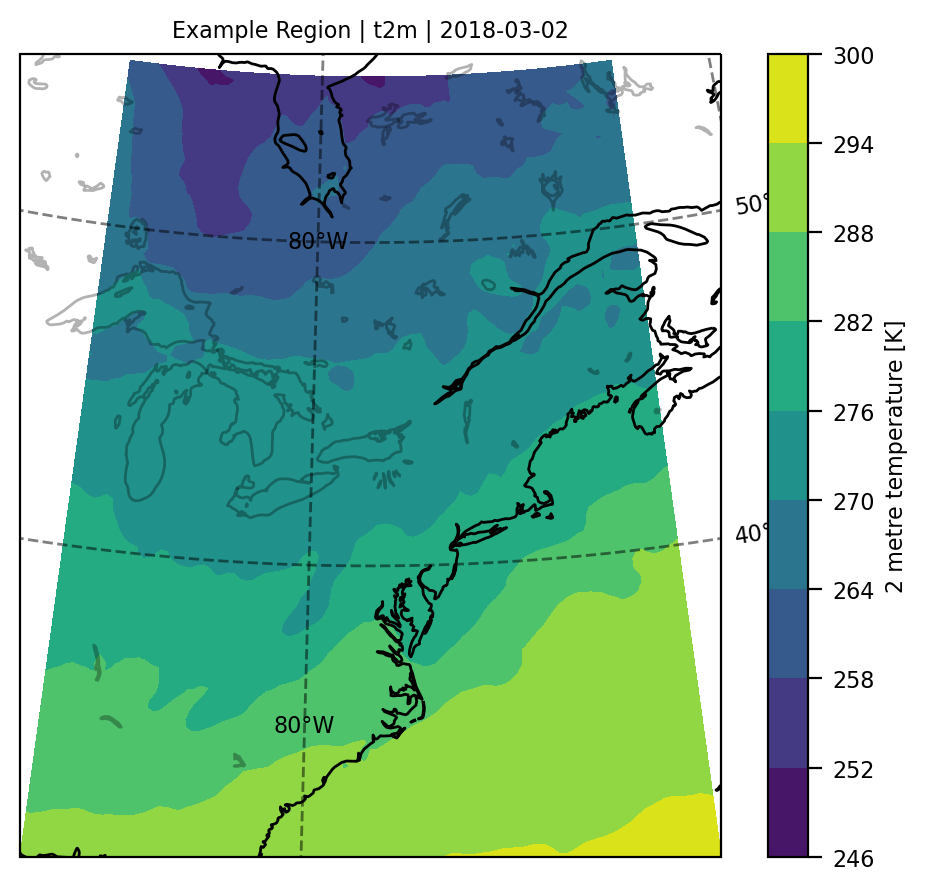

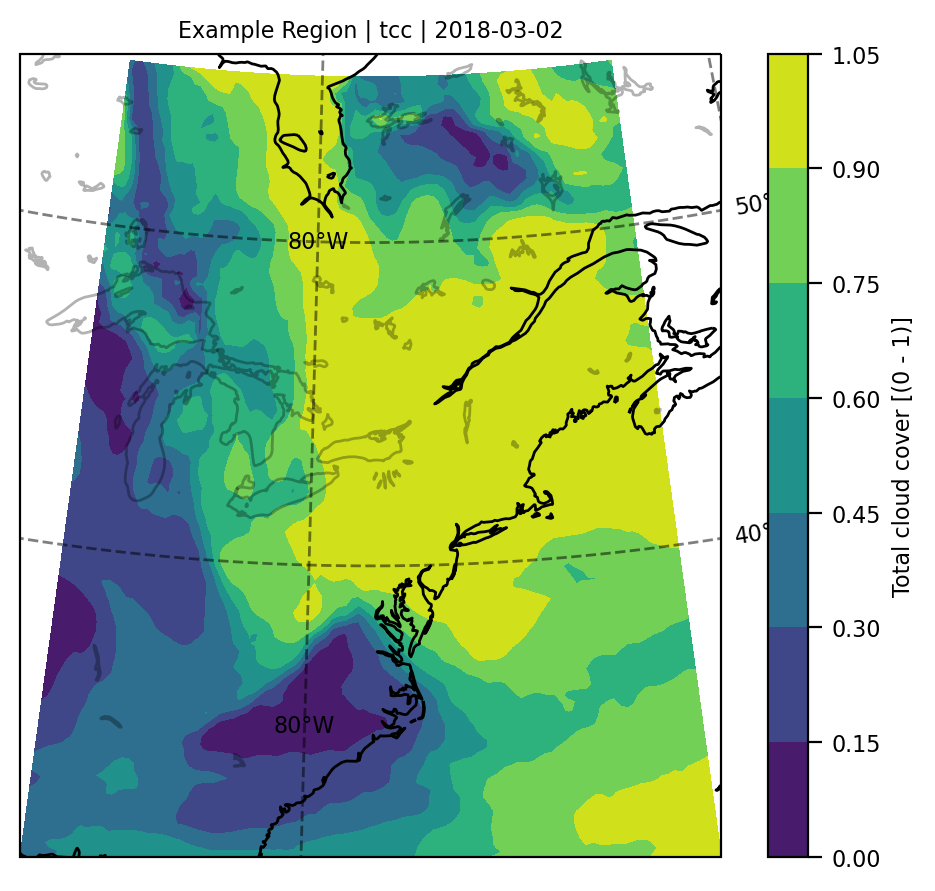

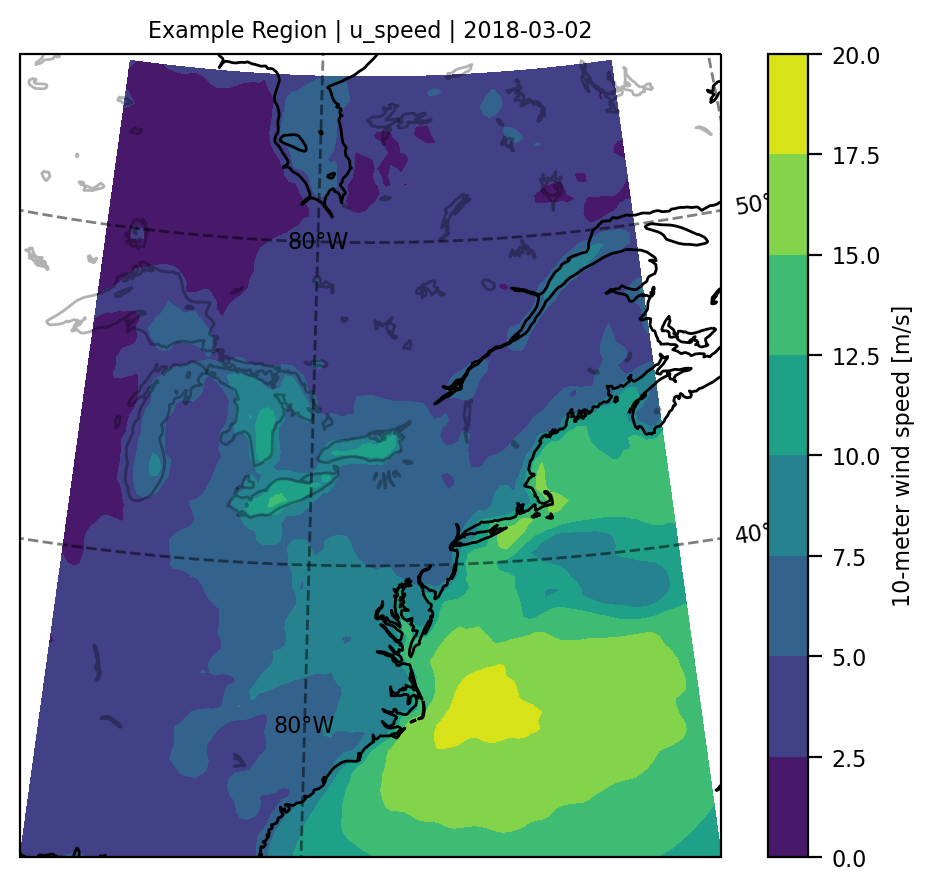

In [13]:
# ERA5_one_day = ERA5_select.isel(time = 29)
# or alternatively, you can speficy the data of the day
day_string = date +'-02'
ERA5_one_day = ERA5_select.sel(time = day_string ).mean('time')

for var in  ['t2m', 'tcc', 'u_speed']:
    F, ax = set_region_figure(lon_range, lat_range)

    #format_axes(ax)
    ax.set_title('Example Region | '+ var +' | '+ day_string)
    dataplot = ax.contourf(ERA5_select.longitude, ERA5_select.latitude, ERA5_one_day[var], transform=ccrs.PlateCarree())
    plt.colorbar(dataplot, orientation='vertical', label = cbar_label(ERA5_select[var]) )
    plt.show()

### *Exercise:*
- Change the day you plot and try to observe how the temperature and the other two variables change betwee the days. We will look at the more carefully below

### 2. Synoptic Variabilty
Lets explore how the temperature, ccloud cover and surface wind speed change in this region due to changes in weather. In most regions of the world the weather changes about every 5 days. Such that it will be helpful to look at the daily data every 5th day.

### Exercise:
To select dailyt means every 5 days, use the data in the selected region 'ERA5_select' an the function xr.resample. Then take the daily mean and then select the 0, 5, 10, and 15th day.
In a last step create the monthly mean of the data and subtract it from the select 5 days such that we can plot the anomalies from the monthly mean:

In [14]:
# annswer
ERA5_synoptic= ERA5_select.resample({'time': '1D'}).mean('time').isel(time=[0,5,10,15])
ERA5_select_mm = ERA5_select.mean('time').compute()
ERA5_synoptic = (ERA5_synoptic - ERA5_select.mean('time')).compute()


Lets then plot the monthly mean and the 4 days foreach variable. Use the framework from the last section for the monthly mean and the function *plot_variable_Facet* like this:


In [15]:
# plot_variable_Facet(dataset, # the calculated data with only 4 selected timesteps 
#                     var_name, #the name of the variable you want to plot (string)
#                     time_dim, "time", #the dimension along the facets of plots will be made, use "time" here 
#                     title # optional string to give the plot a title 
#                    )
                    

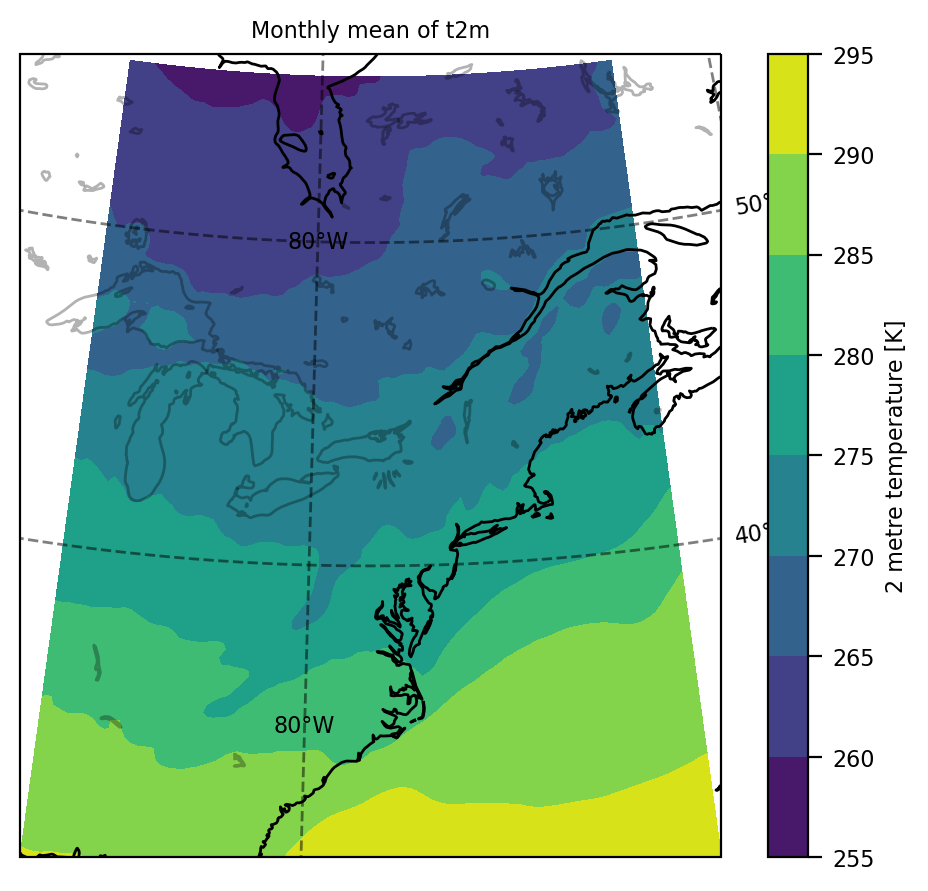

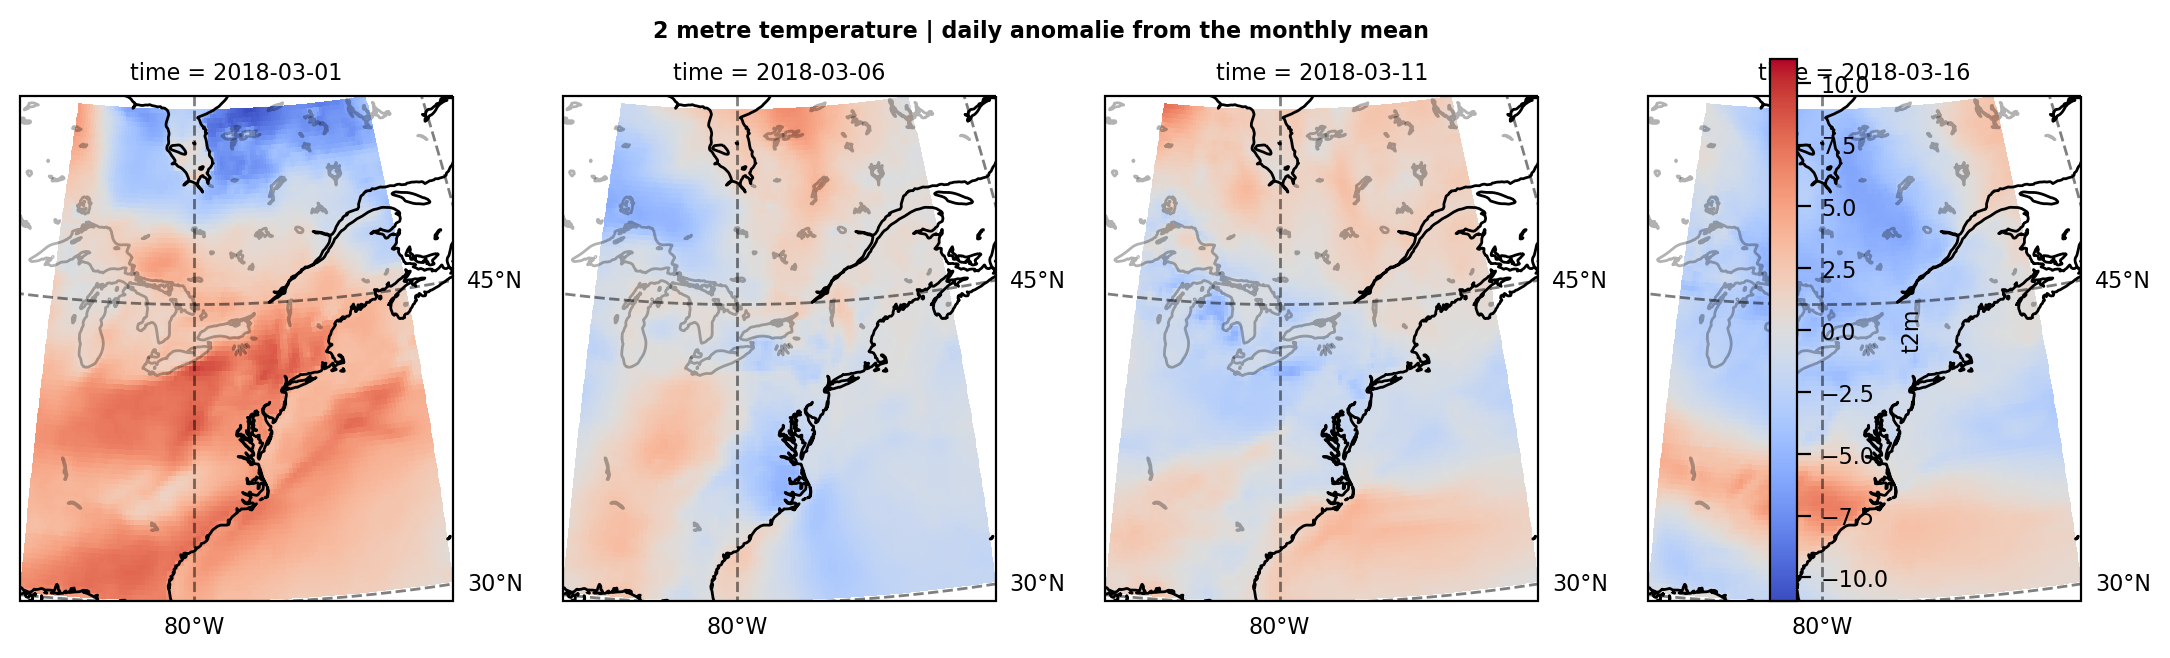

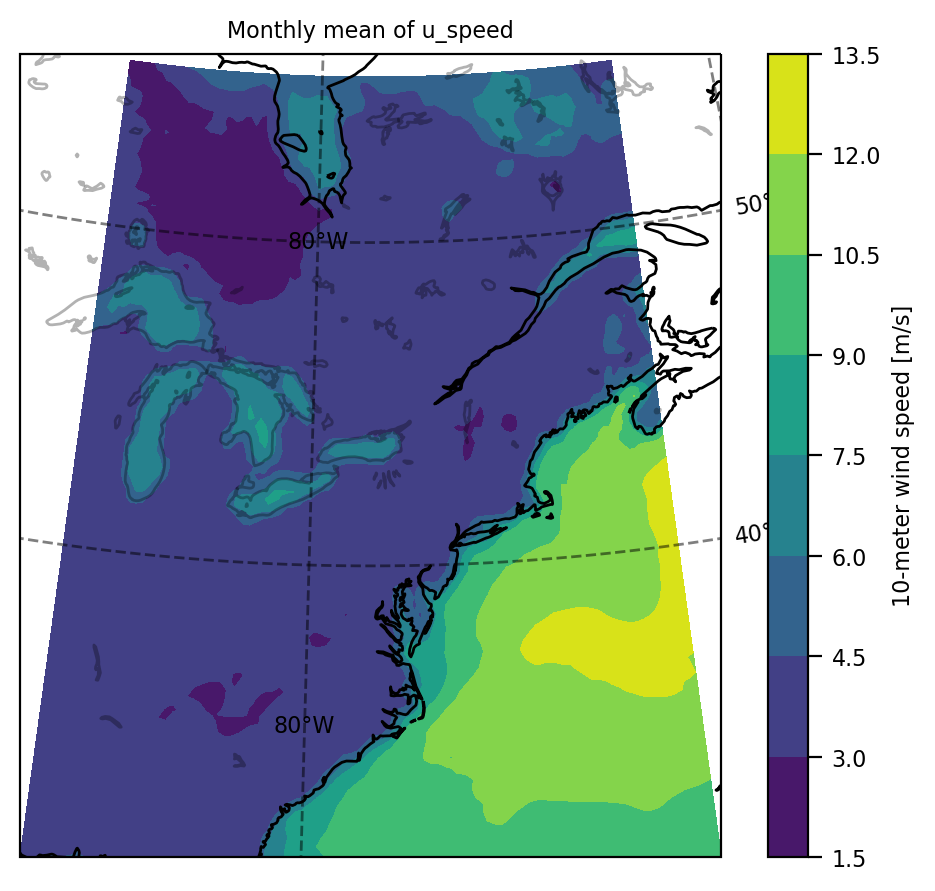

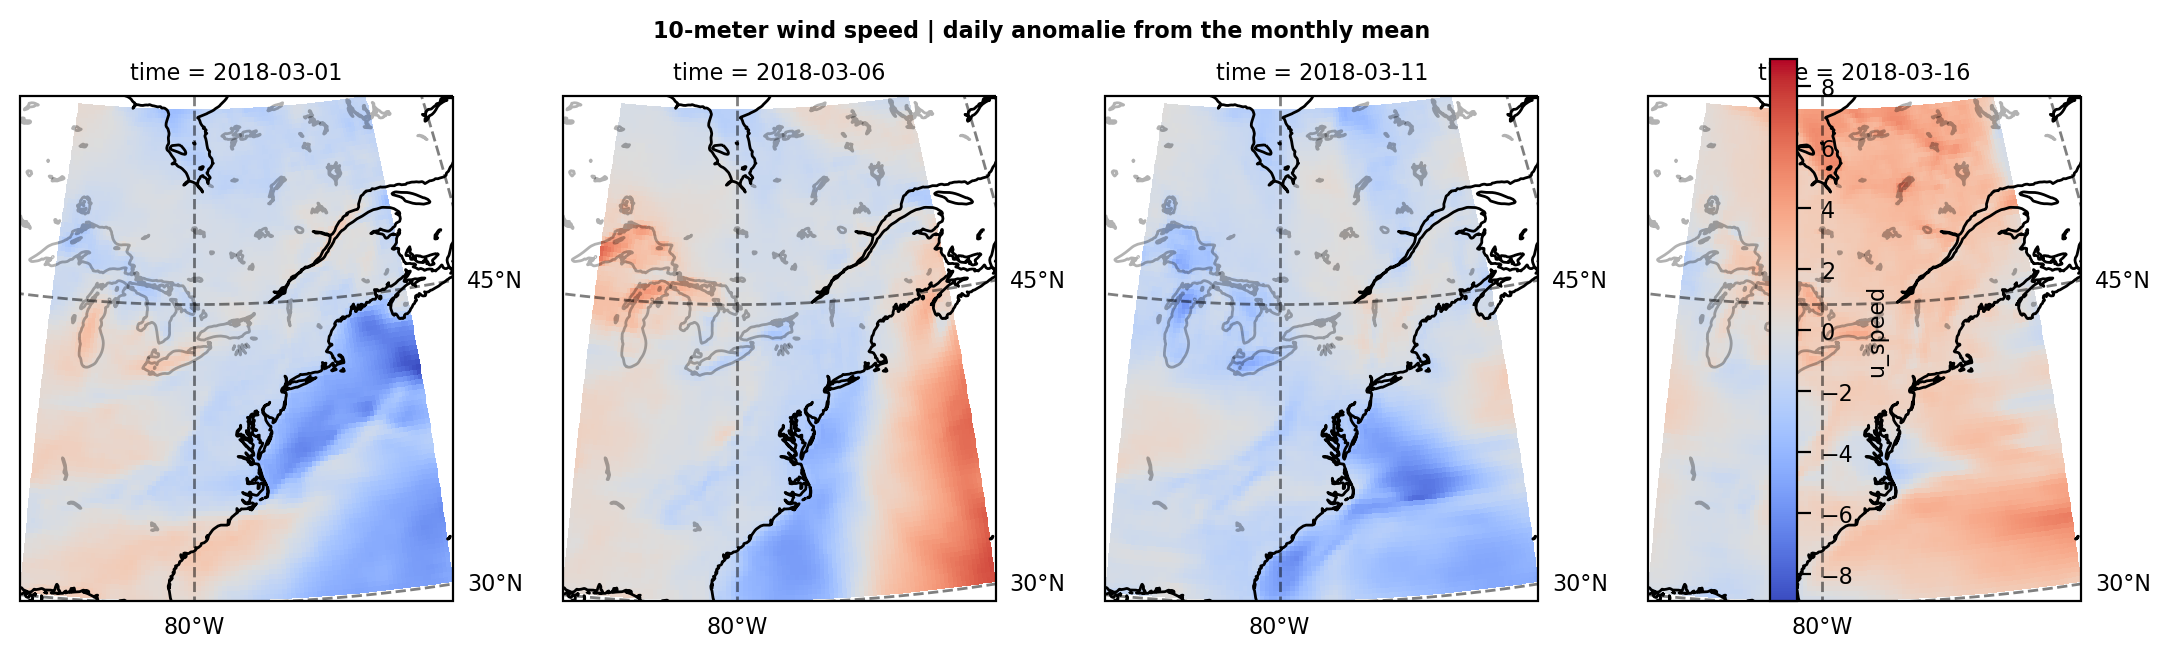

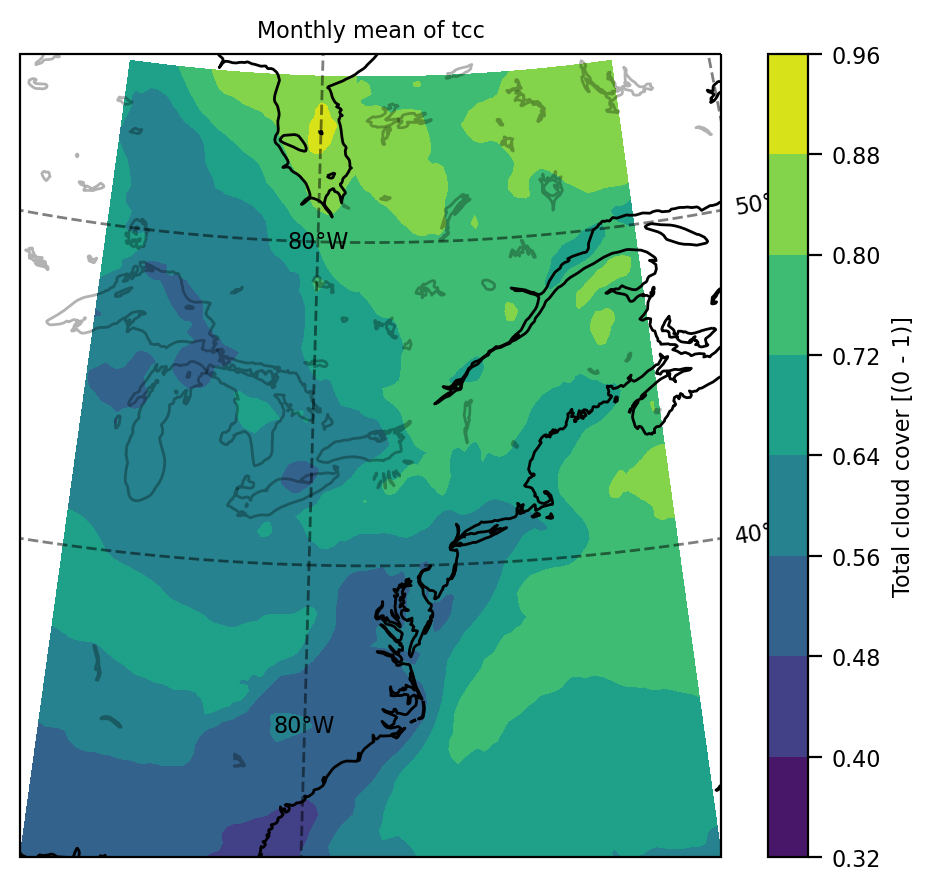

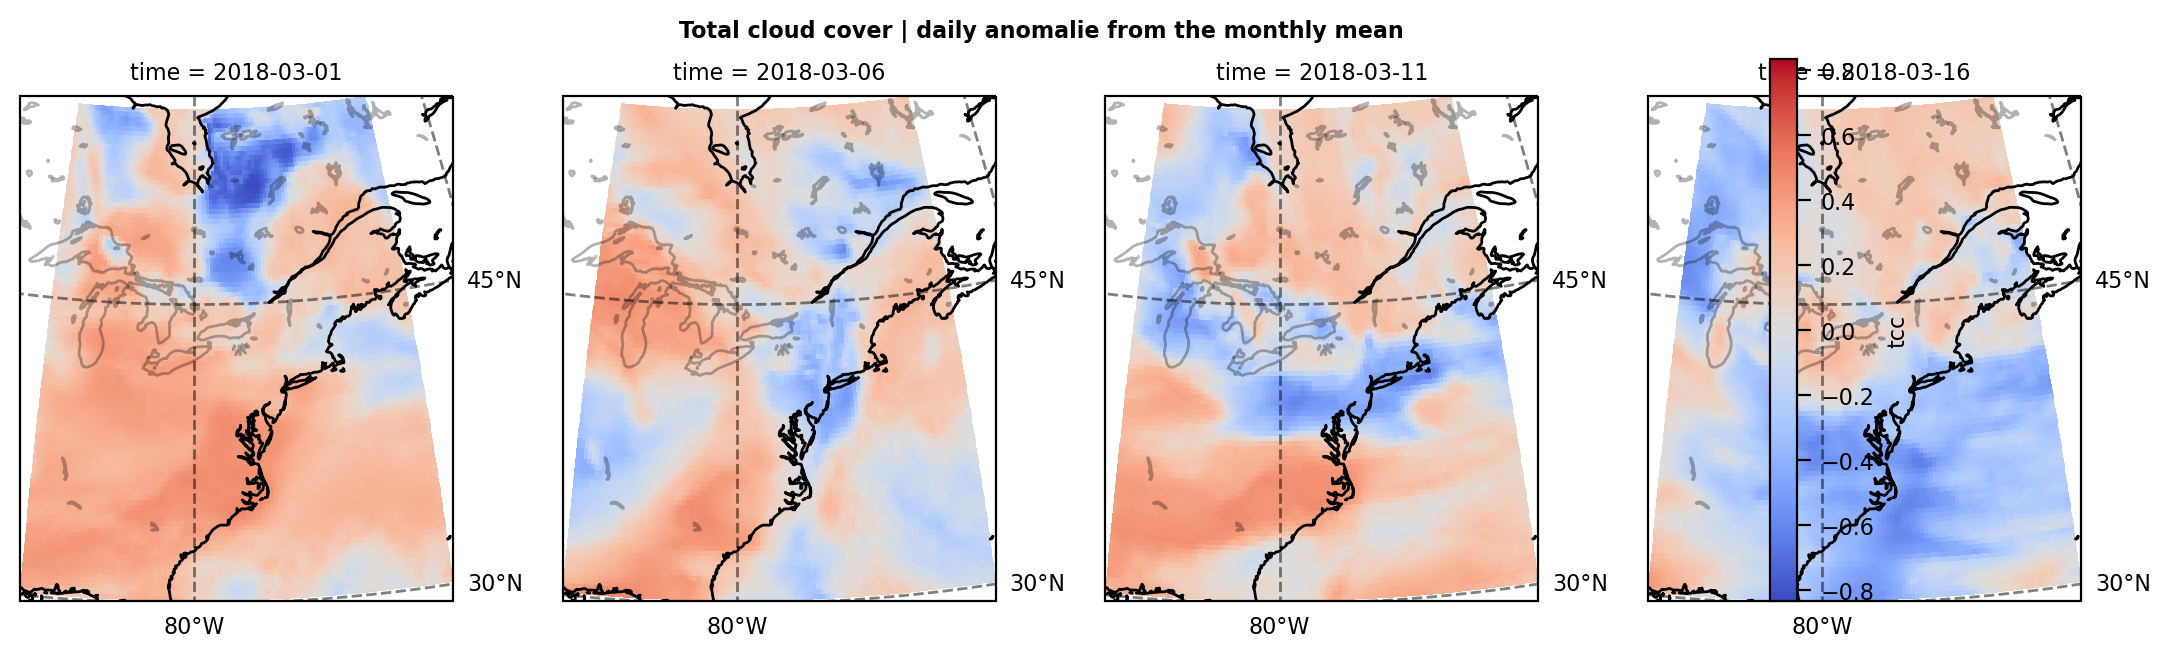

In [16]:
#answer, most compact version
for var in ['t2m', 'u_speed', 'tcc']:
    
    F, ax = set_region_figure(lon_range, lat_range)
    ax.set_title('Monthly mean of '+ var )
    dataplot = ax.contourf(ERA5_select_mm.longitude, ERA5_select_mm.latitude, ERA5_select_mm[var], transform=ccrs.PlateCarree())
    plt.colorbar(dataplot, orientation='vertical', label = cbar_label(ERA5_select[var]) )
    plt.show()
    
    title_str =  ERA5_select[var].attrs['long_name'] + " | daily anomalie from the monthly mean "
    aa = plot_variable_Facet(ERA5_synoptic, var, time_dim ="time", title =title_str)
    plt.show()


you should see 4 panels for each variable. Each panel shows the difference, the anomalie, to the monthly mean, and each panel is 5 days appart. You see that indeed the 

### 3. Durinal cycle - Coastel clouds at the coast on a sunny day?
There is more the synoptic variability (~5 days) in the data. Lets think about how our data varying within 24 hours, but for that we have to look at the hourly data, rather then the daily mean. 
During the day, the sun warms the surface and effect many other variables, like winds and cloud cover, eventhough that really depends on the region and the month you choose. To see the durinal cycle in the data we want to select timestamps in the morning (6 am), at noon (12pm), in the evening (6pm), at midnight (12 am). 

However, the ERA5 data is saved with the UTC (Coordinated Universal Time), such that we have to shift the time axis to the local time. Here we take a shortcut use the longitudinal coordinate as proxi for the local time:

In [17]:
# this functionn takes a longitudinal coodinate and returns the timezone difference compared to UTC. 
# lets use here the center between the longitude boundaries of the domain and express it in the -180 to 180 coordinates again
time_shift = get_time_compared_to_UTC(np.mean(lon_range) - 360)
# define a new coodinate "local_time" and add it to the coordinates of the dataset
ERA5_select.coords['local_time'] = ERA5_select.coords['time'] + time_shift

#this provides us with two time coorinates, one in UTC "time" and one in local time "local time"
print("UTC time   ", ERA5_select.coords['time'][0:2].data)
print("local time ", ERA5_select.coords['local_time'][0:2].data)

UTC time    ['2018-03-01T00:00:00.000000000' '2018-03-01T01:00:00.000000000']
local time  ['2018-02-28T18:00:00.000000000' '2018-02-28T19:00:00.000000000']


Now we want to calculate the typical durinal cycle for the year and the month we chose before. For that, we can group the data by hour of the day, andthen take the mean for each hour of the day over the whole month, and then select hour 0 (midnight), 6, 12, and 24:

In [18]:
ERA5_durinal_cycle= ERA5_select.groupby('local_time.hour').mean('time').sel(hour=[0,6, 12,18]) 

It is often better to show the data as the anomalie from a mean value, to see the differences in the data better. For that, we here just take the mean over the whole month and subtract it. The remaining data is the anomalous data, i.e. the anomalie of the durinal cyle from the monthly mean:


In [19]:
ERA5_durinal_cycle_anomalie = ERA5_durinal_cycle - ERA5_select.mean('time')

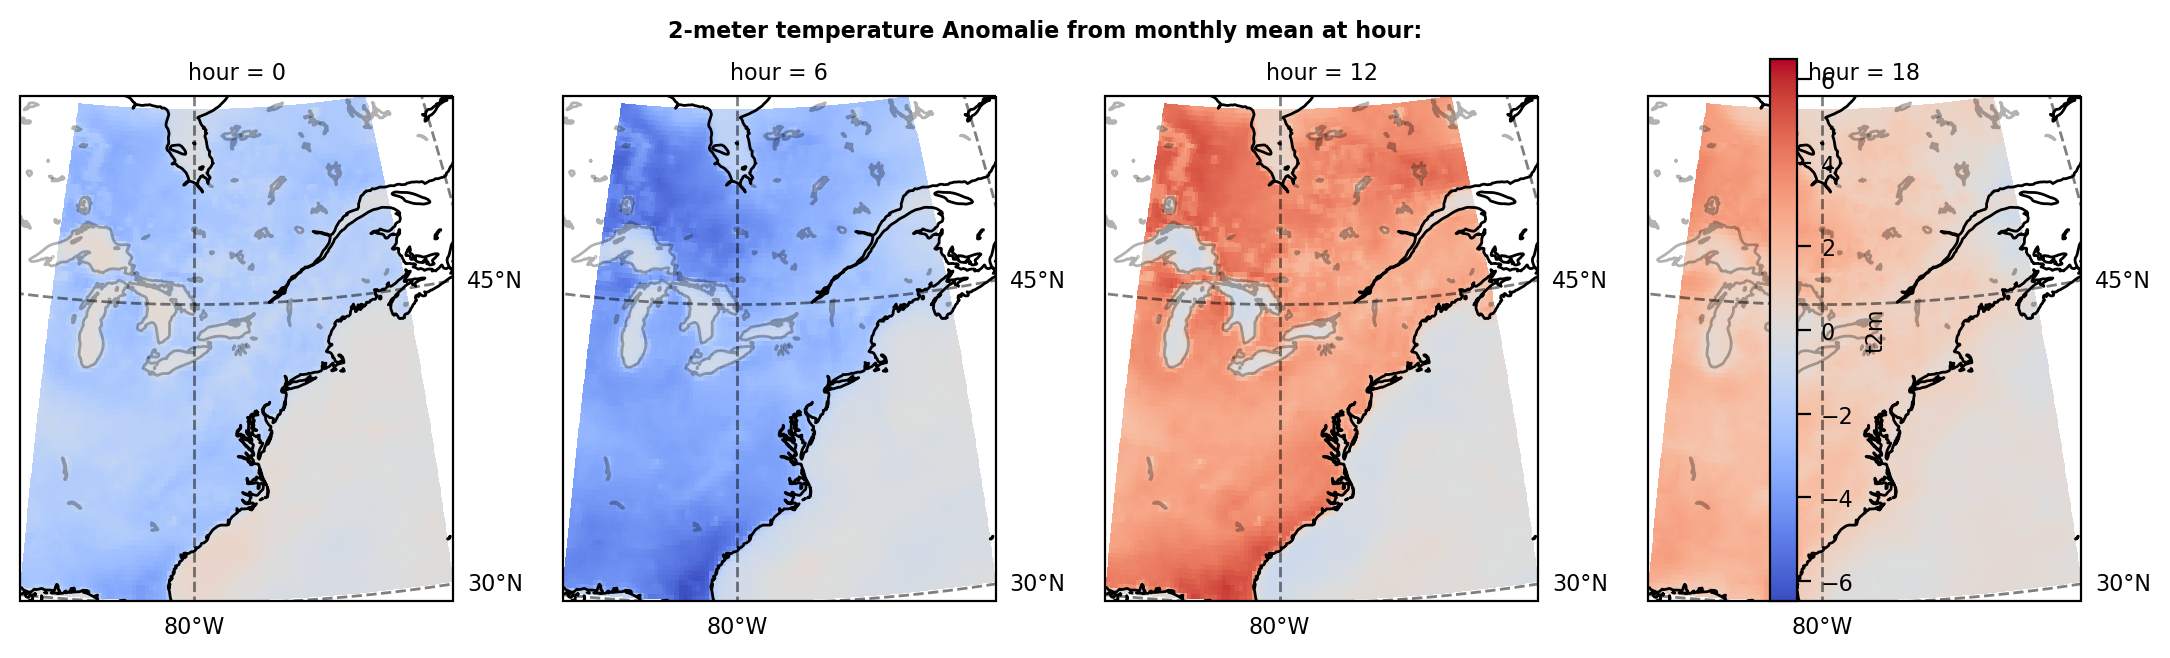

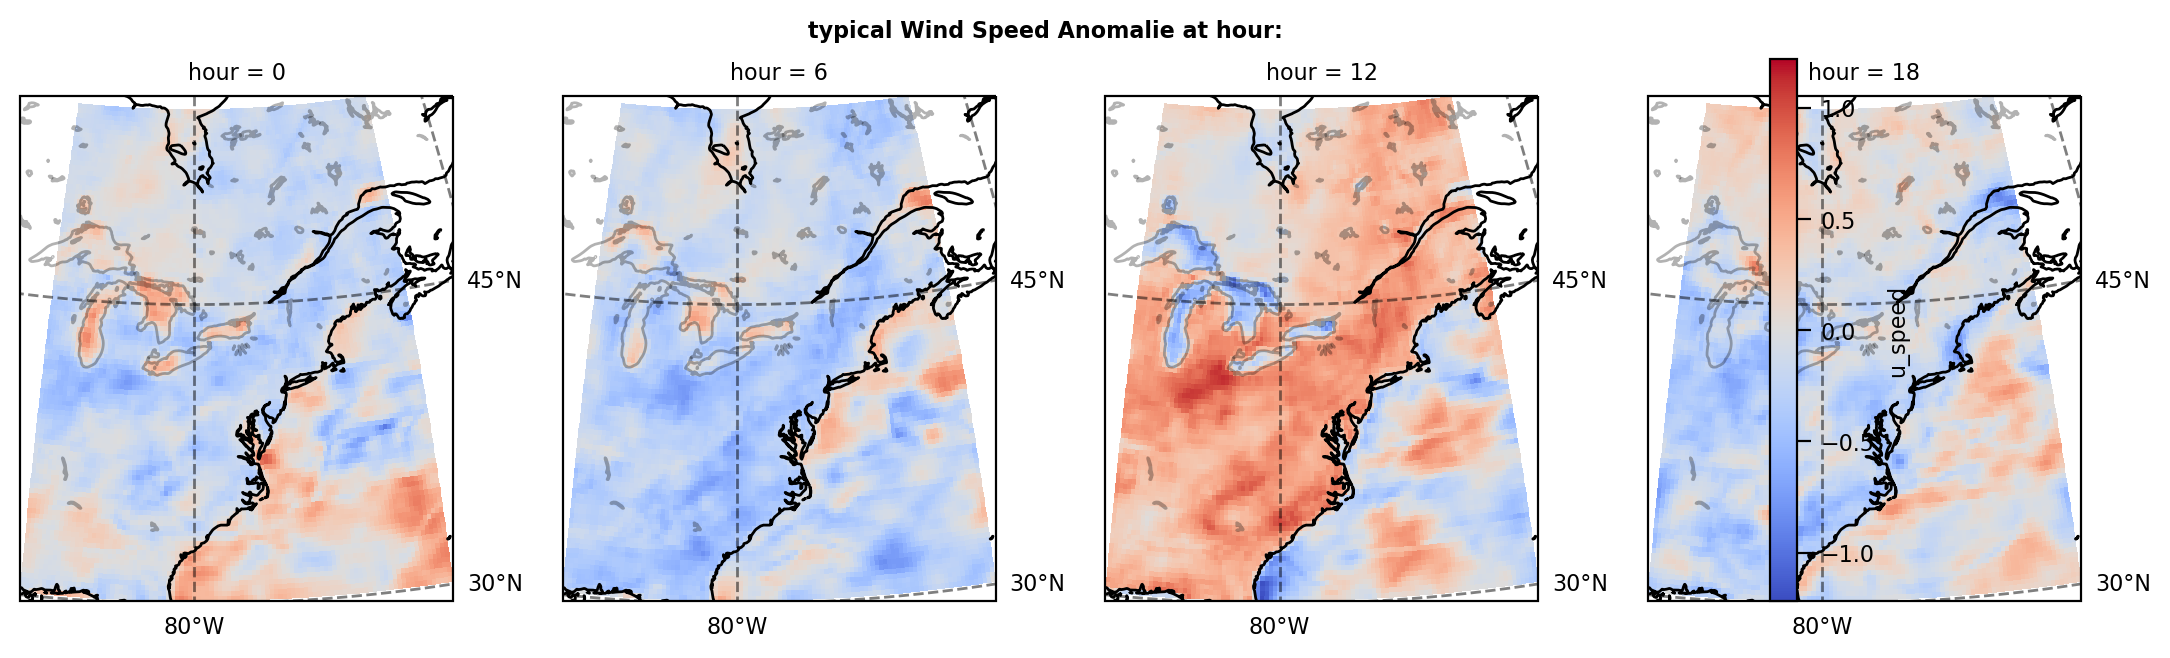

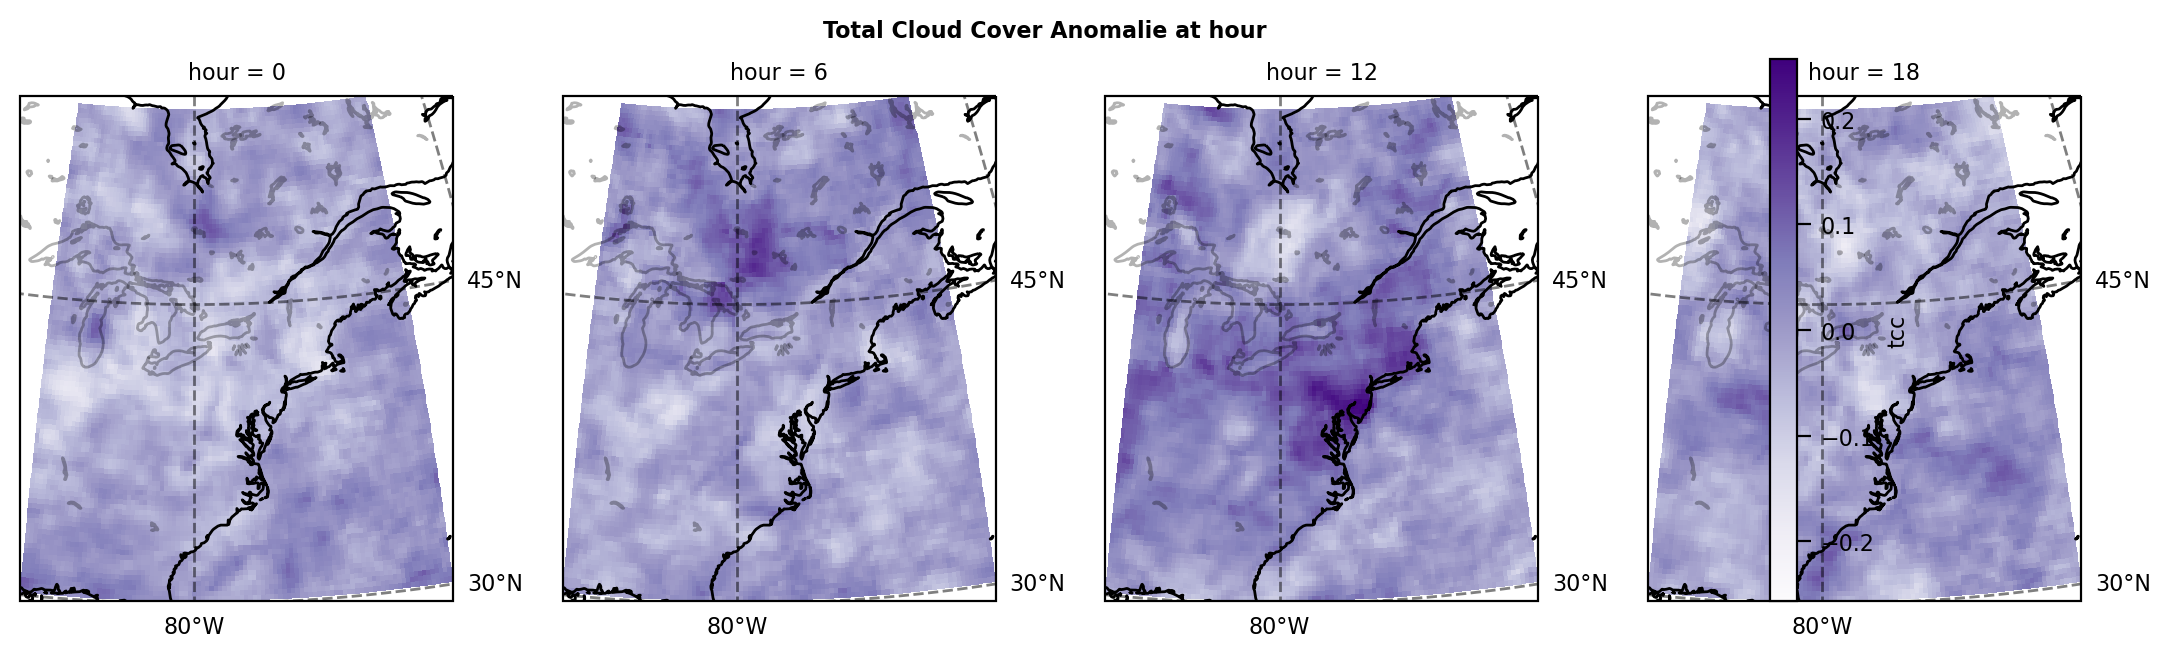

In [20]:
# here we take the anomalie value because the spatial temperature difference can be quiet large.
var= 't2m'
plot_variable_Facet(ERA5_durinal_cycle_anomalie, var, time_dim ="hour", title = "2-meter temperature Anomalie from monthly mean at hour:")
plt.show()

var= 'u_speed'
plot_variable_Facet(ERA5_durinal_cycle_anomalie, var, time_dim ="hour", title = "typical Wind Speed Anomalie at hour:")
ax = plt.gca()
plt.show()

var= 'tcc'
plot_variable_Facet(ERA5_durinal_cycle_anomalie, var, time_dim ="hour", title = "Total Cloud Cover Anomalie at hour", cmap = plt.cm.Purples)
ax = plt.gca()
plt.show()

### *Discussion Questions:*
 - Where in your choosen region do you see the largest typical temperature changes over the course of the day? Where do see the smallest changes? Is that what you expected?
 - Look at the wind speed and the surface temperature. Where do you see the strongest wind anomalies over the course of a day, why? 
 - Where do you see the most cloud cover? how is that related to the winds and the temperature?

#### short answers: 
- Where in your choosen region do you see the largest typical temperature changes over the course of the day? Where do see the smallest changes? Is that what you expected?
the largest changes are over land, because the land repsonses quickly to solar radiation. the changes over the ocean are small, because the ocean need much longer to heat up by the sun.
 - Look at the wind speed and the surface temperature. Where do you see the strongest wind anomalies over the course of a day, why? 
The winds are stronger over land when the solar radiation is highest and the surface the warmest. The changes in the durinal cycle of winds over the ocean however is small (that doesn't mean the winds are generally weak).
 - Where do you see the most cloud cover? how is that related to the winds and the temperature?
 the largest cloud cover is along the coast line because of the sea-breeze phenomonen. it advects cold air from the ocean over to the land and leads to clouds.
 
 have a look here:
 https://www.youtube.com/watch?v=X2Wfp2rPvMY 
 and read here:
 https://resources.eumetrain.org/satmanu/CMs/SB/print.htm 

## Part 4: Another way to look at variabilty: Creating time series

By not you might have realized that there are a lot of change in the data on many time scale, ranging from changes wihtin a day to, changes from day to day and from month to month. This *variability* in the data important to understand when we do climate analysis. 

Rather then plotting spatial maps for different time steps or time scale, in this last part of the tutorial we will create timeseries from the same data you look at already. That is staight foreward. Instead of taking the mean in time, we take the mean in space. 

In [21]:
ERA5_ts = ERA5_select.mean(['longitude', 'latitude']).compute()

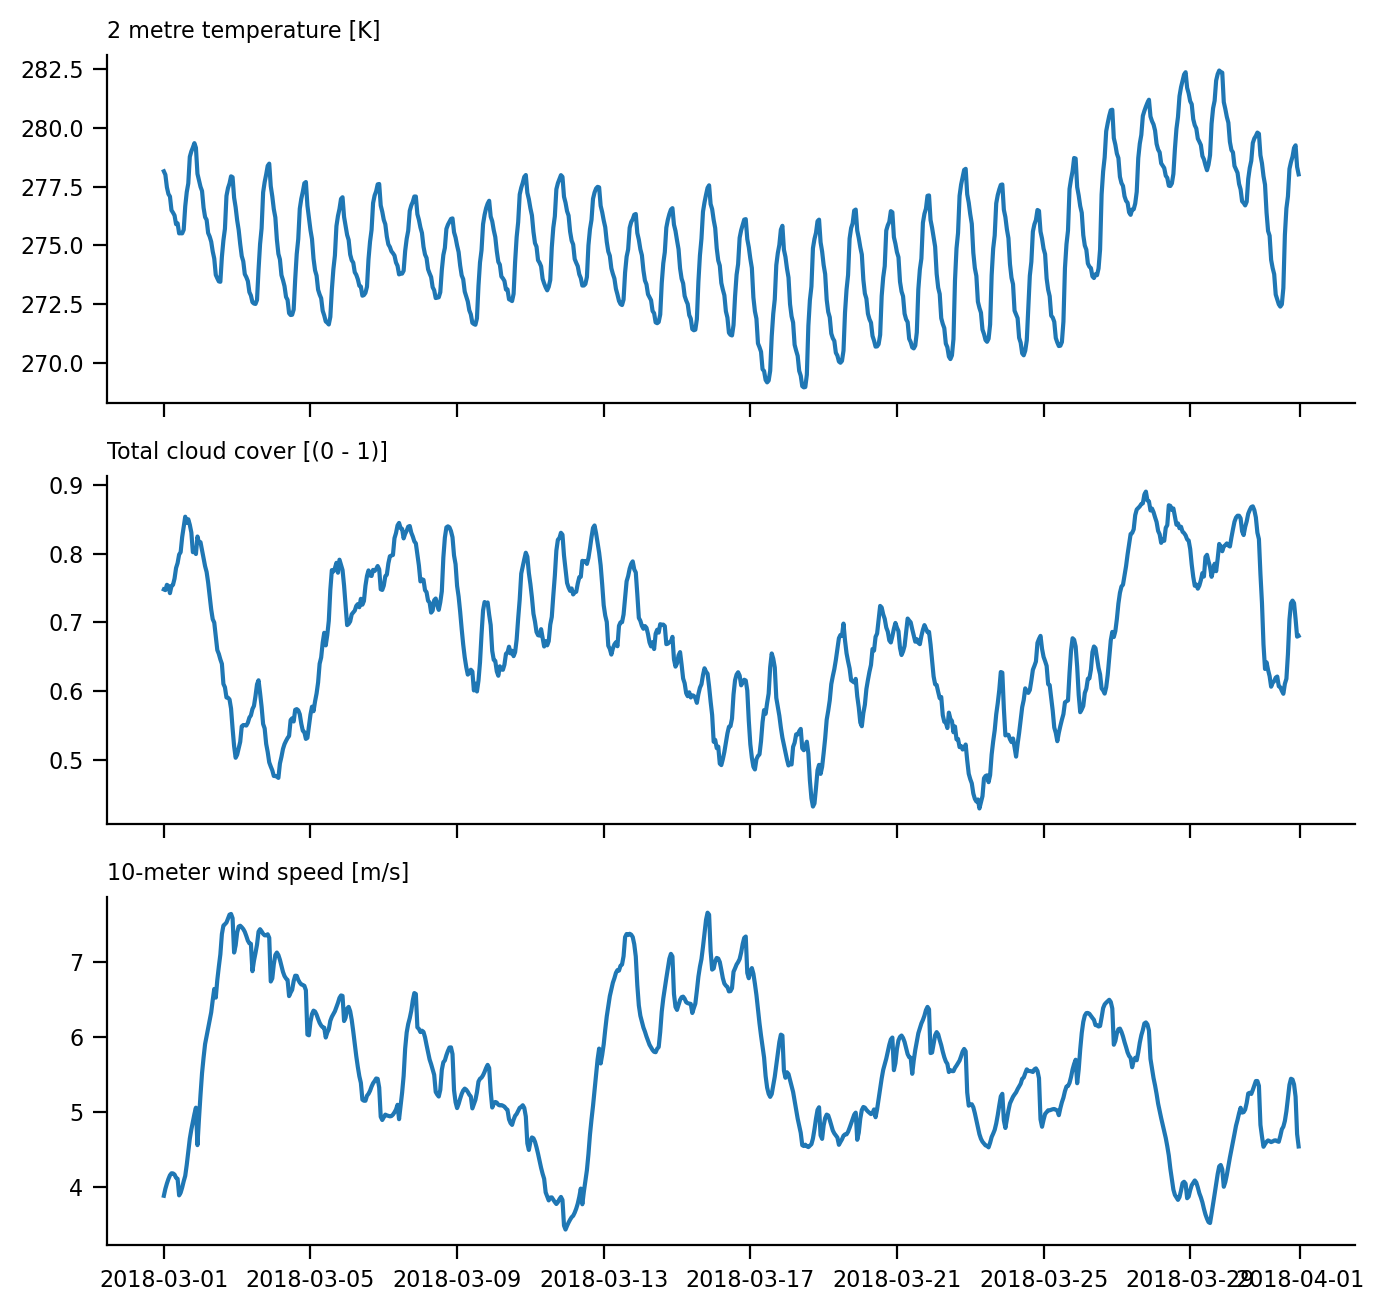

In [22]:
fig, ax_list = plt.subplots(3, 1, figsize=(7, 6.6),  sharex=True)

for var, ax in  zip(['t2m', 'tcc', 'u_speed'], ax_list ):
    
    ax.plot(ERA5_ts.time, ERA5_ts[var])
    ax.set_title(cbar_label(ERA5_select[var]), loc='left')
plt.show()

### *Questions*
- Which variable is dominated by the durinal cycle?
- which variable by the synoptic scale (~ 5 day)?

## *Exercise*:
In this final exercise, let's compare the effect of spatial averaging and temporal avering on the data.
For that, focus on the surface wind speed 'u_speed' and make four different time series that represent the wind speed in the region
- 1) ERA5_ts_spatial_average  - *this is the timeseries of the spatial average of data for each timestep (as above)*
- 2) ERA5_ts_point - *this is the hourly timeseries on data at one grid point in the center of your domain*
- 3) ERA5_ts_point_daily  - *this is the timeseries of the point data but resamples the daily values*
- 3) ERA5_ts_spatial_average_daily  - *this is the timeseries of the spatially averaged data but also resamples the daily values*

plot the data!

In [23]:
# answers:
var = 'u_speed'
ERA5_ts_spatial_average = ERA5_select[var].mean(['longitude', 'latitude']).compute()
ERA5_ts_point           = ERA5_select[var].sel( longitude =np.mean(lon_range) , latitude =np.mean(lat_range), method ='nearest' ).compute()

ERA5_ts_point_daily     = ERA5_ts_point.resample({'time' :'1D'}, offset= '12h').mean()
ERA5_ts_spatial_average_daily = ERA5_ts_spatial_average.resample({'time' :'1D'}, offset= '12h').mean()

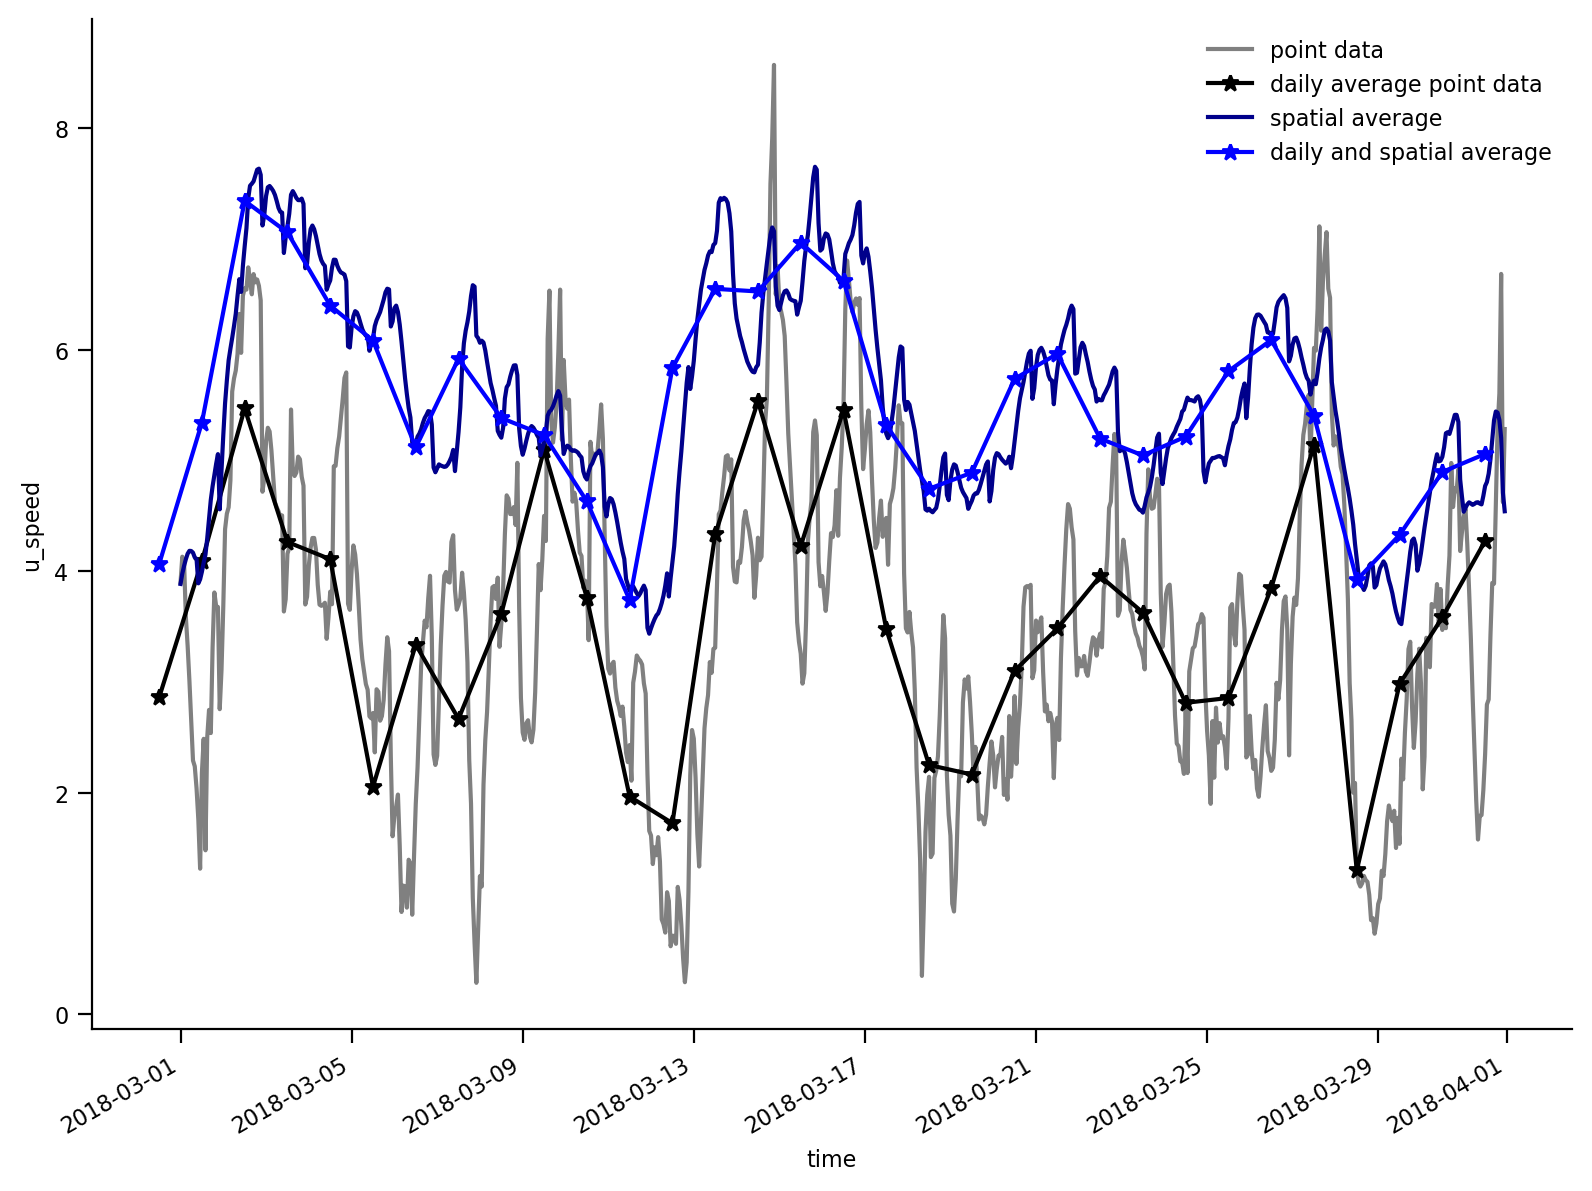

In [24]:
#answer part II:
ERA5_ts_point.plot(color= 'gray', label = 'point data')
ERA5_ts_point_daily.plot(color= 'black', marker='*', label = 'daily average point data')

ERA5_ts_spatial_average.plot(color= 'darkblue', label = 'spatial average')
ERA5_ts_spatial_average_daily.plot(color= 'blue', marker='*', label = 'daily and spatial average')
plt.legend()

## *Questions*:
- What is the difference in these 4 four time series?
- What version represents the wind speed in the region the best way?


#comments:

All four timeseries are different represenations on the wind variability in the region. 
The spatial averaging acts as a smothing of the data and hene has less varaiblity the the point data. However, we often don't have all the data all the time and instead just some *sample* of the wind speed, as for example in the point data. 
But that point data shows a different variability than then spatial average, regardless if we resample to 1 day or not. Be aware that the resolution of the data and the way it is averaged and sampled matters!

---
# Summary

In this tutorial you learned how to access and navigaate ERA5 renanlysis data. You can now select subregions in the renalysis and take averages or subsamples in space and time.
You have seen how averaging data reduces the variabilty and that any dataset, ranging from timeseries to spatial maps has a resolution and a timestep that are important to know when understanding the data.


---
# Bonus: Extending the timeseries analysis to long timeperiods


Use the tools provided above and make a timeseries of the surface temperature und and surface wind over the 30 years of the ERA5 data. First select the region in ERA5 as before but know use all time steps. Then resample to daily means and plot each variable in a single planel or figure.
